In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import zero_one_loss
import random
import pickle
import os
import dask
from dask import compute
import dask.bag as db
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
from random import randrange
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import RidgeClassifier

from sklearn import preprocessing

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.naive_bayes import BernoulliNB

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [9]:
algorithm_performance_dict = {
    'RandomForest': 0.855,
    'GradientBoosting':0.875,
    'DecisionTree':0.801,
    'RidgeClassifier':0.725,
    'SVC':0.612,
    'BernoulliNB':0.663,
    'LDA':0.743
}

considered_sensors_in_journal_paper = [
'cooling_electricity [W]',
'electricity_facility [W]',
'whole_building_facility_total_hvac_electric_demand_power [W]',
'rooftop_supply_fan_fan_electric_energy [W]',
'fans_electricity [W]',
'gas_facility [W]',
'rooftop_heatingcoil_heating_coil_heating_energy [W]',
'heating_electricity [W]',
'heating_gas [W]',
'interiorequipment_electricity [W]',
'interiorlights_electricity [W]',
'environment_site_diffuse_solar_radiation_rate_per_area [W/m2]',#: 'weather_meter',
'environment_site_direct_solar_radiation_rate_per_area [W/m2]',#:'weather_meter',
'environment_site_outdoor_air_barometric_pressure [Pa]',#:'weather_meter',
'environment_site_outdoor_air_drybulb_temperature [C]',#:'weather_meter',
'environment_site_outdoor_air_relative_humidity [%]',#:'weather_meter',
'environment_site_outdoor_air_wetbulb_temperature [C]',#:'weather_meter',
'environment_site_rain_status []',#:'weather_meter',
'rooftop_cooling_coil_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'rooftop_heating_coil_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'rooftop_mixed_air_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'rooftop_supply_fan_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_102_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_102_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_103_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_103_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_104_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_104_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_105_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_105_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_106_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_106_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_202_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_202_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_203_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_203_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_204_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_204_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_205_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_205_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_206_supply_inlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'room_206_vav_reheat_damper_outlet_system_node_temperature [C]',#:'system_node_temperature_sensor',
'1f_plenum_zone_air_relative_humidity [%]',#: 'room_humidity_sensor',
'2f_plenum_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_101_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_102_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_103_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_104_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_105_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_106_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_201_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_202_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_203_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_204_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_205_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'room_206_zone_air_relative_humidity [%]',#:'room_humidity_sensor',
'1f_plenum_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'2f_plenum_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_101_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_102_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_103_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_104_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_105_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_106_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_201_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_202_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_203_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_204_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_205_zone_mean_air_temperature [C]',#:'room_temperature_sensor',
'room_206_zone_mean_air_temperature [C]',#:'room_temperature_sensor'
]

In [3]:
def adding_inaccuracy_to_raw_data(FDD_data_df, sensor_type_fault_probability = 0.33,
                                  failure_bias_drift_precision_conditional_probability = [0.25, 0.25, 0.25, 0.25]):
    
    raw_FDD_data = FDD_data_df[considered_sensors_in_journal_paper].copy()
    
    sensor_category_dict = {
        'cooling_electricity [W]': 'electiricty_meter',
        'electricity_facility [W]': 'electiricty_meter',
        'whole_building_facility_total_hvac_electric_demand_power [W]':'electiricty_meter',
        'rooftop_supply_fan_fan_electric_energy [W]':'electiricty_meter',
        'fans_electricity [W]':'electiricty_meter',
        'gas_facility [W]':'gas_meter',
        'rooftop_heatingcoil_heating_coil_heating_energy [W]': 'energy_meter',
        'room_102_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'room_103_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'room_104_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'room_105_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'room_106_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'room_202_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'room_203_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'room_204_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'room_205_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'room_206_reheat_coil_heating_coil_heating_energy [W]':'energy_meter',
        'heating_electricity [W]':'electiricty_meter',
        'heating_gas [W]': 'gas_meter',
        'interiorequipment_electricity [W]':'electiricty_meter',
        'interiorlights_electricity [W]':'electiricty_meter',
        'environment_site_diffuse_solar_radiation_rate_per_area [W/m2]': 'weather_meter',
        'environment_site_direct_solar_radiation_rate_per_area [W/m2]':'weather_meter',
        'environment_site_outdoor_air_barometric_pressure [Pa]':'weather_meter',
        'environment_site_outdoor_air_drybulb_temperature [C]':'weather_meter',
        'environment_site_outdoor_air_relative_humidity [%]':'weather_meter',
        'environment_site_outdoor_air_wetbulb_temperature [C]':'weather_meter',
        'environment_site_rain_status []':'weather_meter',
        'model_outdoor_air_node_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_1_system_node_current_density_volume_flow_rate [m3/s]': 'system_node_flow_rate',
        'node_10_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_11_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_12_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_13_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_14_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_15_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_16_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_17_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_18_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_19_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_2_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_20_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_21_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_22_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_23_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_24_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_25_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_26_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_27_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_28_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_3_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_4_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_6_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_7_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_8_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'node_9_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'rooftop_cooling_coil_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'rooftop_heating_coil_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'rooftop_mixed_air_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'rooftop_supply_fan_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_102_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_102_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_103_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_103_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_104_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_104_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_105_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_105_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_106_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_106_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_202_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_202_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_203_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_203_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_204_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_204_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_205_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_205_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_206_supply_inlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'room_206_vav_reheat_damper_outlet_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{0628a441-dd58-4747-b49f-b343da599f6d}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{37d30d88-4e83-4f6c-98c7-a29c55ba3e84}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{38113ce7-41ec-4cfc-9439-9e0eb1e4167e}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{3a71b498-dd57-4750-ab29-7013d94b7420}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{466be93f-f26d-4e42-ab5f-0c90ed714020}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{6ec5fd0e-2850-4c87-bc5f-bc1e2d2e5109}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{76064095-69fd-4710-a706-3caca6b1930a}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{8411efaa-a23b-4a5a-be30-f1fa819dbe95}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{9129fe30-5384-4db8-8e33-0bb342dd4a49}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{ced936e0-0614-4c8a-a4d6-aa0b5c362790}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{d5737138-bc5b-4212-acf2-fd3235458210}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        '{d9fe34a3-6952-4cd4-96fc-8fec69429e39}_system_node_current_density_volume_flow_rate [m3/s]':'system_node_flow_rate',
        'model_outdoor_air_node_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_1_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_10_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_11_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_12_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_13_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_14_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_15_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_16_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_17_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_18_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_19_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_2_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_20_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_21_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_22_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_23_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_24_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_25_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_26_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_27_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_28_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_3_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_4_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_6_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_7_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_8_system_node_temperature [C]':'system_node_temperature_sensor',
        'node_9_system_node_temperature [C]':'system_node_temperature_sensor',
        'rooftop_cooling_coil_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'rooftop_heating_coil_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'rooftop_mixed_air_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'rooftop_supply_fan_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_102_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_102_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_103_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_103_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_104_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_104_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_105_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_105_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_106_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_106_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_202_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_202_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_203_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_203_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_204_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_204_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_205_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_205_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_206_supply_inlet_system_node_temperature [C]':'system_node_temperature_sensor',
        'room_206_vav_reheat_damper_outlet_system_node_temperature [C]':'system_node_temperature_sensor',
        '{0628a441-dd58-4747-b49f-b343da599f6d}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{37d30d88-4e83-4f6c-98c7-a29c55ba3e84}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{38113ce7-41ec-4cfc-9439-9e0eb1e4167e}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{3a71b498-dd57-4750-ab29-7013d94b7420}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{466be93f-f26d-4e42-ab5f-0c90ed714020}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{6ec5fd0e-2850-4c87-bc5f-bc1e2d2e5109}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{76064095-69fd-4710-a706-3caca6b1930a}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{8411efaa-a23b-4a5a-be30-f1fa819dbe95}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{9129fe30-5384-4db8-8e33-0bb342dd4a49}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{ced936e0-0614-4c8a-a4d6-aa0b5c362790}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{d5737138-bc5b-4212-acf2-fd3235458210}_system_node_temperature [C]':'system_node_temperature_sensor',
        '{d9fe34a3-6952-4cd4-96fc-8fec69429e39}_system_node_temperature [C]':'system_node_temperature_sensor',
        '1f_plenum_zone_air_relative_humidity [%]': 'room_humidity_sensor',
        '2f_plenum_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_101_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_102_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_103_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_104_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_105_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_106_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_201_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_202_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_203_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_204_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_205_zone_air_relative_humidity [%]':'room_humidity_sensor',
        'room_206_zone_air_relative_humidity [%]':'room_humidity_sensor',
        '1f_plenum_zone_mean_air_temperature [C]':'room_temperature_sensor',
        '2f_plenum_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_101_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_102_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_103_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_104_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_105_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_106_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_201_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_202_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_203_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_204_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_205_zone_mean_air_temperature [C]':'room_temperature_sensor',
        'room_206_zone_mean_air_temperature [C]':'room_temperature_sensor'
    }

    sensor_type_fault_probability_table = {
     'electiricty_meter': sensor_type_fault_probability,
     'system_node_temperature_sensor': sensor_type_fault_probability,
     'room_temperature_sensor': sensor_type_fault_probability,
     'energy_meter': sensor_type_fault_probability,
     'weather_meter': sensor_type_fault_probability,
     'room_humidity_sensor': sensor_type_fault_probability,
     'system_node_flow_rate': sensor_type_fault_probability,
     'gas_meter': sensor_type_fault_probability
    }

    failure_bias_drift_precision_conditional_probability_table = {
     'electiricty_meter': failure_bias_drift_precision_conditional_probability,
     'system_node_temperature_sensor': failure_bias_drift_precision_conditional_probability,
     'room_temperature_sensor': failure_bias_drift_precision_conditional_probability,
     'energy_meter': failure_bias_drift_precision_conditional_probability,
     'weather_meter': failure_bias_drift_precision_conditional_probability,
     'room_humidity_sensor': failure_bias_drift_precision_conditional_probability,
     'system_node_flow_rate': failure_bias_drift_precision_conditional_probability,
     'gas_meter': failure_bias_drift_precision_conditional_probability
    }

    all_sensor_list = pd.DataFrame([])
    all_sensor_list['sensors'] = sensor_category_dict.keys()
    all_sensor_list['sensor_type'] = all_sensor_list['sensors'].map(sensor_category_dict)
    all_sensor_list['probability'] = all_sensor_list['sensor_type'].map(sensor_type_fault_probability_table)

    probability_results = []
    for x in all_sensor_list.probability:  
        a_list = [0,1]
        distribution = [1-x, x]
        random_number = random.choices(a_list, distribution)[0]
        probability_results.append(random_number)

    all_sensor_list['probability_results'] = probability_results

    all_sensor_list['conditional_probability'] = all_sensor_list['sensor_type'].map(failure_bias_drift_precision_conditional_probability_table)

    probability_results = []
    for x in all_sensor_list.conditional_probability:
        a_list = ['failure','bias','drift','precision']
        distribution = x
        random_number = random.choices(a_list, distribution)[0]
        probability_results.append(random_number)

    all_sensor_list['conditional_probability_results'] = probability_results    

    for x in considered_sensors_in_journal_paper:
        temp = all_sensor_list.loc[all_sensor_list.sensors == x]
        if temp.probability_results.values[0] == 1:
            if temp.conditional_probability_results.values[0] == 'bias':
                raw_FDD_data.loc[:,x] = raw_FDD_data.loc[:,x] + raw_FDD_data.loc[:,x].mean() * 0.05
            elif temp.conditional_probability_results.values[0] == 'drift':
                raw_FDD_data.loc[:,x] = raw_FDD_data.loc[:,x] + np.linspace(0, raw_FDD_data.loc[:,x].mean()*0.1, num=len(raw_FDD_data.loc[:,x]))
            elif temp.conditional_probability_results.values[0] == 'precision':
                #random_list = [random.uniform(- example_data.loc[:,x].mean() * 0.05, example_data.loc[:,x].mean() * 0.05) for j in range(len(example_data))]
                random_list = np.random.normal(0,0.05,len(raw_FDD_data)) * raw_FDD_data.loc[:,x].mean()
                raw_FDD_data.loc[:,x] = raw_FDD_data.loc[:,x] + random_list
            else:
                raw_FDD_data.loc[:,x] = raw_FDD_data.loc[:,x].mean()
            #print(f'Processed:{x}, {temp.conditional_probability_results.values[0]}')

    return raw_FDD_data

In [4]:
def save_inaccuracy_injected_data(weather, j):
    if not os.path.exists(f'data_inaccuracy_injected_{j}/{weather}/{weather}/'):
        os.makedirs(f'data_inaccuracy_injected_{j}/{weather}/{weather}/')
    print(f'Generating the {j}th inaccuracy injected data')
    print(f'Processing: {weather}')
    prefixed = [filename for filename in os.listdir(f'data/{weather}/{weather}/') if 'sensors' in filename]
    for file_name,i in zip(prefixed,range(len(prefixed))):
        print(f'    Processing: {i+1}/{len(prefixed)}')
        temp_raw_FDD_data = pd.read_csv(f'data/{weather}/{weather}/{file_name}')
        temp_raw_FDD_data = temp_raw_FDD_data.groupby(temp_raw_FDD_data.index // (4)).mean()

        temp_raw_FDD_data = temp_raw_FDD_data[considered_sensors_in_journal_paper]
        if j != 0:
            inaccuracy_injected_FDD_data = adding_inaccuracy_to_raw_data(temp_raw_FDD_data)
        else:
            inaccuracy_injected_FDD_data = adding_inaccuracy_to_raw_data(temp_raw_FDD_data, sensor_type_fault_probability = 0)

        inaccuracy_injected_FDD_data.to_csv(f'data_inaccuracy_injected_{j}/{weather}/{weather}/{file_name}', index = None)

In [5]:
# # generate fault injected data
# #for weather in ['AK_Fairbanks', 'FL_Miami', 'KY_Louisville', 'MN_Duluth', 'SAU_Riyadh', 'TN_Knoxville', 'VA_Richmond']:
# for weather in ['TN_Knoxville']:        
#     results = []
#     for x in range(11):
#         y = dask.delayed(save_inaccuracy_injected_data)(weather ,x)
#         results.append(y)

#     results = dask.compute(*results)

Module 2

Create fault probalistic table for sensors

In [6]:
selected_fault_types = ['air_handling_unit_fan_motor_degradation',
                        'biased_economizer_sensor_mixed_t',
                        'duct_fouling',
                        'economizer_opening_stuck',
                        'hvac_setback_error_delayed_onset',
                        'hvac_setback_error_no_overnight_setback',
                        'hvac_setback_error_early_termination',
                        'improper_time_delay_setting_in_occupancy_sensors',
                        'lighting_setback_error_delayed_onset',
                        'lighting_setback_error_no_overnight_setback',
                        'lighting_setback_error_early_termination',
                        'return_air_duct_leakages',
                        'supply_air_duct_leakages',
                        'thermostat_bias',
                        'baseline'
                       ]

In [7]:
def normalize_data(X_train):
    # normalize data
    column_name = X_train.columns
    x = X_train.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X_train = pd.DataFrame(x_scaled, columns = column_name)
    return X_train

In [8]:
def calculate_error_and_features(inputs, output, algorithm):
    cv = KFold(n_splits=4, shuffle=True, random_state = 42)
    results = []
    important_features = []
    # i = 0
    
    for train_index, test_index in cv.split(inputs):
        X_train, X_test = inputs.iloc[train_index].copy(), inputs.iloc[test_index].copy()
        y_train, y_test = output.iloc[train_index].copy(), output.iloc[test_index].copy()
        # Fit the model on training data
        
        # Original
        if algorithm == 'RandomForest':
            regr = RandomForestClassifier(n_estimators = 20, random_state=42)
        
        # Ensemble methods
        if algorithm == 'GradientBoosting':
            regr = GradientBoostingClassifier(random_state = 42, n_estimators = 20)
            
        # Tree
        # Decision Tree Classifier
        if algorithm == 'DecisionTree':
            regr = DecisionTreeClassifier(random_state = 42)
        
        # Linear
        # RidgeClassifier
        if algorithm == 'RidgeClassifier':
            regr = RidgeClassifier()
    
            # normalize data
            X_train = normalize_data(X_train)
            X_test = normalize_data(X_test)
        
        # Support Vector Machine
        # SVC
        if algorithm == 'SVC':
#             regr = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            regr = SVC(kernel ='linear')
            
            # normalize data
            X_train = normalize_data(X_train)
            X_test = normalize_data(X_test)

        # Naive Bayes
        # BernoulliNB
        if algorithm == 'BernoulliNB':
            regr = BernoulliNB()            

            # normalize data
            X_train = normalize_data(X_train)
            X_test = normalize_data(X_test)    
        
#         # Nearest Neighbors
#         # Gaussian process classification (GPC) based on Laplace approximation
#         if algorithm = 'GPC':
#             kernel = 1.0 * RBF(1.0)
#             regr = GaussianProcessClassifier(kernel=kernel, random_state=0)

        # Linear and Quadratic Discriminant Analysis
        # Linear Discriminant Analysis
        if algorithm == 'LDA':
            regr = LinearDiscriminantAnalysis()
            # normalize data
            X_train = normalize_data(X_train)
            X_test = normalize_data(X_test)                
            
        regr.fit(X_train, y_train)
    #     # save model
    #     filename = f'model/saved_model_{i}_{weather}.sav'
    #     pickle.dump(regr, open(filename, 'wb'))
    #     i += 1

        # feature importance or ranking
        if algorithm in ['RandomForest','GradientBoosting','DecisionTree']:
            feature_importance_temp = pd.DataFrame([])
            feature_importance_temp.loc[:,'sensor_name'] = inputs.columns
            feature_importance_temp.loc[:,'importance'] = regr.feature_importances_
            important_features += feature_importance_temp.sort_values(
                by=['importance'], ascending = False).sensor_name[0:40].tolist()
        
        if algorithm in ['RidgeClassifier','SVC','BernoulliNB','LDA']:
            feature_importance_temp = regr.coef_

            feature_importance_df = pd.DataFrame(abs(pd.DataFrame(feature_importance_temp)).sum(0), columns = ['importance'])
            feature_importance_df['sensor_name'] = X_test.columns.tolist()
            feature_importance_df = feature_importance_df[['sensor_name','importance']]
            # , columns = X_test.columns
            important_features = feature_importance_df.sort_values(by=['importance'], ascending = False).sensor_name[0:40].tolist()
        
        # Generate predictions on the test data and collect
        y_test_predicted = regr.predict(X_test)
        CV_error = zero_one_loss(y_test, y_test_predicted, normalize=True)
#         CV_error = accuracy_score(y_test, y_test_predicted)
        break

    important_features = list(set(important_features))
    
    CV_error_df = pd.DataFrame([CV_error], columns = ['CV_Error'])
    
    important_features_df = pd.DataFrame([])
    important_features_df['important_features'] = important_features
    
    return [CV_error_df, important_features_df]

In [9]:
# # Generate original error and features

# # for weather in ['AK_Fairbanks', 'FL_Miami', 'KY_Louisville', 'MN_Duluth', 'SAU_Riyadh', 'TN_Knoxville', 'VA_Richmond']:
# # for weather in ['MN_Duluth']:
# for weather in ['TN_Knoxville']:
# # for weather in ['FL_Miami', 'KY_Louisville', 'SAU_Riyadh', 'TN_Knoxville', 'VA_Richmond']:
#     print(f'Processing: {weather}')
#     meta_data_name = [filename for filename in os.listdir(f'data/{weather}/{weather}/') if 'sensors' not in filename][0]
#     meta_data = pd.read_csv(f'data/{weather}/{weather}/{meta_data_name}')
#     ids_temp = meta_data.loc[meta_data.fault_type.isin(selected_fault_types)][['id', 'fault_type']]
#     final_data_df = pd.DataFrame([])
#     for id_n in ids_temp.id:
#         print(f'    Processing: {id_n}')
#         temp_data = pd.read_csv(f'data/{weather}/{weather}/{id_n}_sensors.csv')
#         temp_data = temp_data.groupby(temp_data.index // (4)).mean()
# #         temp_data = temp_data.iloc[:,0:-8]
#         temp_data['label'] = ids_temp.loc[ids_temp.id == id_n].fault_type.values[0]
#         final_data_df = pd.concat([final_data_df, temp_data], axis = 0, ignore_index = True)
#     final_data_df = final_data_df[considered_sensors_in_journal_paper + ['label']]
    
#     final_data_df = final_data_df.iloc[::23, :].reset_index(drop = True)
    
#     final_data_df.to_csv(f'results/journal_paper/{weather}_original.csv', index = None)
    
#     inputs = final_data_df.iloc[:,0:-1].copy()
#     output = final_data_df.iloc[:,-1].copy()

#     CV_error_df, important_features_df = calculate_error_and_features(inputs, output)

#     CV_error_df.to_csv(f'results/journal_paper/{weather}_original_CV_Error.csv', index = None)
    
#     important_features_df.to_csv(f'results/journal_paper/{weather}_original_important_features.csv', index = None)

In [10]:
def deal_with_injected_data(weather, j, algorithm):
    print(f'Processing: {weather}')
    meta_data_name = [filename for filename in os.listdir(f'data/{weather}/{weather}/') if 'sensors' not in filename][0]
    meta_data = pd.read_csv(f'data/{weather}/{weather}/{meta_data_name}')
    ids_temp = meta_data.loc[meta_data.fault_type.isin(selected_fault_types)][['id', 'fault_type']]
    final_data_df = pd.DataFrame([])
    for id_n in ids_temp.id:
        print(f'    Processing: {id_n}')
        temp_data = pd.read_csv(f'data_inaccuracy_injected_{j}/{weather}/{weather}/{id_n}_sensors.csv')
#             temp_data = temp_data.groupby(temp_data.index // (4)).mean()
#         temp_data = temp_data.iloc[:,0:-8]
        temp_data['label'] = ids_temp.loc[ids_temp.id == id_n].fault_type.values[0]
        final_data_df = pd.concat([final_data_df, temp_data], axis = 0, ignore_index = True)
    final_data_df = final_data_df[considered_sensors_in_journal_paper + ['label']]

    final_data_df = final_data_df.iloc[::23, :]

    final_data_df.to_csv(f'results/algorithm_compatibility/{algorithm}_{weather}_inaccuracy_injected_{j}.csv', index = None)

    inputs = final_data_df.iloc[:,0:-1].copy()
    output = final_data_df.iloc[:,-1].copy()

    CV_error_df, important_features_df = calculate_error_and_features(inputs, output, algorithm)

    CV_error_df.to_csv(f'results/algorithm_compatibility/{algorithm}_{weather}_inaccuracy_injected_{j}_CV_Error.csv', index = None)

    important_features_df.to_csv(f'results/algorithm_compatibility/{algorithm}_{weather}_inaccuracy_injected_{j}_important_features.csv', index = None)

In [11]:
# deal with fault injected data, calculate error and features
#     for weather in ['AK_Fairbanks', 'FL_Miami', 'KY_Louisville', 'MN_Duluth', 'SAU_Riyadh', 'TN_Knoxville', 'VA_Richmond']:
# for algorithm in ['RandomForest','GradientBoosting','DecisionTree','RidgeClassifier','SVC','BernoulliNB']:
for algorithm in ['LDA']:
    for weather in ['TN_Knoxville']:        
        results = []
        for x in range(11):
            y = dask.delayed(deal_with_injected_data)(weather ,x, algorithm)
            results.append(y)

        results = dask.compute(*results)

Processing: TN_KnoxvilleProcessing: TN_Knoxville
Processing: TN_Knoxville
Processing: TN_Knoxville
Processing: TN_KnoxvilleProcessing: TN_Knoxville

Processing: TN_Knoxville

Processing: TN_Knoxville
Processing: TN_KnoxvilleProcessing: TN_Knoxville

Processing: TN_Knoxville
    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae

    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae
    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae
    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae

    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae
    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae
    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae
    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae
    Processing: 3f9c38dd-02c2-47bf-945c-ae401017ccae
    Processing: e0baeb44-227c-4374-9c14-6693f3f6c9b1
    Processing: e0baeb44-227c-4374-9c14-6693f3f6c9b1
    Processing: e0baeb44-227c-4374-9

    Processing: f593e0a1-89ce-43a6-9604-b4941c21b168    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538

    Processing: f593e0a1-89ce-43a6-9604-b4941c21b168
    Processing: f593e0a1-89ce-43a6-9604-b4941c21b168
    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538
    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538
    Processing: 4345039d-0761-4bd1-ac50-e8b2ae8d95e0
    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538
    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538
    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538
    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538
    Processing: 4345039d-0761-4bd1-ac50-e8b2ae8d95e0
    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538
    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538
    Processing: 6e73ef37-ecd6-4b4e-b733-209eee55b538
    Processing: 4345039d-0761-4bd1-ac50-e8b2ae8d95e0
    Processing: 777bf6d8-4811-46d5-a6d9-1dc591bfee78
    Processing: 4345039d-0761-4bd1-ac50-e8b2ae8d95e0
    Processing: 4345039d-0761-4bd1-ac50-e8b2ae

    Processing: aac13a3c-5b0e-418f-af92-bfb1341289d3
    Processing: aac13a3c-5b0e-418f-af92-bfb1341289d3
    Processing: 6fc4a681-7172-42d3-ac61-65fb699a6ba5    Processing: aac13a3c-5b0e-418f-af92-bfb1341289d3

    Processing: 8750bd5a-7e5b-464f-b995-0e7796150465
    Processing: 8750bd5a-7e5b-464f-b995-0e7796150465
    Processing: 8750bd5a-7e5b-464f-b995-0e7796150465
    Processing: 6fc4a681-7172-42d3-ac61-65fb699a6ba5
    Processing: 8750bd5a-7e5b-464f-b995-0e7796150465
    Processing: 8750bd5a-7e5b-464f-b995-0e7796150465
    Processing: 8750bd5a-7e5b-464f-b995-0e7796150465
    Processing: 8750bd5a-7e5b-464f-b995-0e7796150465
    Processing: 8750bd5a-7e5b-464f-b995-0e7796150465
    Processing: 8750bd5a-7e5b-464f-b995-0e7796150465
    Processing: 888088c9-b20b-4258-b472-325012f3e4b6
    Processing: 6fc4a681-7172-42d3-ac61-65fb699a6ba5
    Processing: 6fc4a681-7172-42d3-ac61-65fb699a6ba5
    Processing: 6fc4a681-7172-42d3-ac61-65fb699a6ba5
    Processing: 888088c9-b20b-4258-b472-325012

    Processing: c844915d-544c-4bf5-a8cb-7be626581d6d
    Processing: f30df307-c192-40aa-934f-ae7e2b92cd08
    Processing: a5d611cb-ce91-4808-93eb-d8f7011f8f9d
    Processing: c844915d-544c-4bf5-a8cb-7be626581d6d
    Processing: a5d611cb-ce91-4808-93eb-d8f7011f8f9d
    Processing: a5d611cb-ce91-4808-93eb-d8f7011f8f9d
    Processing: a5d611cb-ce91-4808-93eb-d8f7011f8f9d
    Processing: c844915d-544c-4bf5-a8cb-7be626581d6d
    Processing: a5d611cb-ce91-4808-93eb-d8f7011f8f9d
    Processing: a5d611cb-ce91-4808-93eb-d8f7011f8f9d
    Processing: a5d611cb-ce91-4808-93eb-d8f7011f8f9d
    Processing: c812d454-c3c7-4e05-a2bb-4d8c4a22ae5e
    Processing: a5d611cb-ce91-4808-93eb-d8f7011f8f9d
    Processing: c844915d-544c-4bf5-a8cb-7be626581d6d
    Processing: c812d454-c3c7-4e05-a2bb-4d8c4a22ae5e
    Processing: c844915d-544c-4bf5-a8cb-7be626581d6d
    Processing: c844915d-544c-4bf5-a8cb-7be626581d6d
    Processing: c812d454-c3c7-4e05-a2bb-4d8c4a22ae5e
    Processing: c844915d-544c-4bf5-a8cb-7be626

In [107]:
# aggregate feature selection results:
aggregated_sensor_results = pd.DataFrame([])
for algorithm in ['RandomForest','GradientBoosting','DecisionTree','SVC','BernoulliNB']:
    algorithm_selected_sensor_df = pd.read_csv(f'D:/jupyternotebook/FDD_sensor_impact_framework_applied_to_FRP/results/algorithm_compatibility/{algorithm}_final_sensor_importance_TN_Knoxville.csv')
    aggregated_sensor_results = pd.concat([aggregated_sensor_results, algorithm_selected_sensor_df[['sensor','selected possibility']].iloc[0:40]], axis = 0)

processed_aggregated_sensor_results = aggregated_sensor_results.groupby(['sensor']).sum().sort_values(by='selected possibility', ascending=False)
processed_aggregated_sensor_results.to_csv('results/algorithm_compatibility/aggregated_sensor_selection_results.csv')

In [40]:
# plot the results
def plot_results(algorithm):
    # for weather in ['AK_Fairbanks', 'FL_Miami', 'KY_Louisville', 'MN_Duluth', 'SAU_Riyadh', 'TN_Knoxville', 'VA_Richmond']:
    for weather in ['TN_Knoxville']:
        error_total = []
        for j in range(1,11):
            error_df = pd.read_csv(f'results/algorithm_compatibility/{algorithm}_{weather}_inaccuracy_injected_{j}_CV_Error.csv')
            # use dummy values below for the accuracy
            error_processed = 1-error_df.values[0][0]
            error_total.append(error_processed)
        s = pd.Series(error_total)
#         s = s * algorithm_performance_dict[algorithm] / s.mean() - 0.02
        s = s + algorithm_model_performance_shift_dict[algorithm]
        ax = s.plot.kde()
        # original model performance
        original_performance = pd.read_csv(f'results/algorithm_compatibility/{algorithm}_{weather}_inaccuracy_injected_0_CV_Error.csv')
        original_performance = 1- original_performance.iloc[0,0]
        #plt.axvline(x=original_performance, label='none-fault performance', c='r')
        plt.axvline(x=algorithm_performance_dict[algorithm], label='none-fault performance', c='r')
        plt.ylabel('Density(Dimensionless)')
        #plt.xlim(0.7,1)
        plt.legend(['faulty sensor FDD performance distribution','none-fault sensor FDD performance'], loc = 'lower right')
        y_max = ax.get_ylim()[1]
        accuracy_mean = s.mean()
        accuracy_std = s.std()
#         plt.text(0.75, y_max * 0.8, 'mean: {0:.3f}\nstd:'.format(accuracy_mean) + '{0:.3f}'.format(accuracy_std))
        plt.title(f'{algorithm}, {weather}, Kernel Density Estimation (KDE) Plot\nFDD Accuracy under the Impact of Sensor Inaccuracy Injection')
        plt.xlabel('FDD Accuracy (Correct Classification Rate)')
        plt.show()

In [41]:
algorithm_performance_dict = {
    'RandomForest': 0.855,
    'GradientBoosting':0.875,
    'DecisionTree':0.801,
    'RidgeClassifier':0.725,
    'SVC':0.612,
    'BernoulliNB':0.663,
    'LDA':0.743
}

In [94]:
algorithm_model_performance_shift_dict = {
    'RandomForest': -0.1445,
    'GradientBoosting':-0.12,
    'DecisionTree':-0.17,
    'RidgeClassifier':0.35,
    'SVC':0,
    'BernoulliNB':0.57,
    'LDA':0.38
}

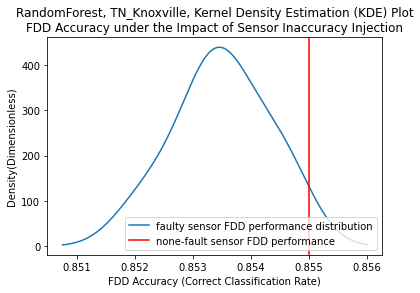

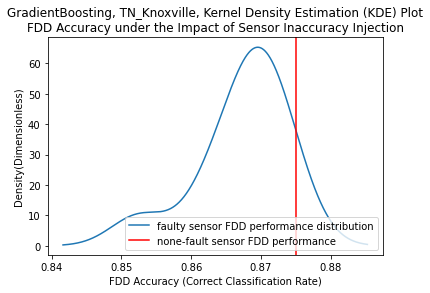

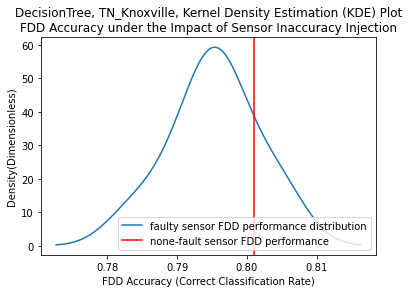

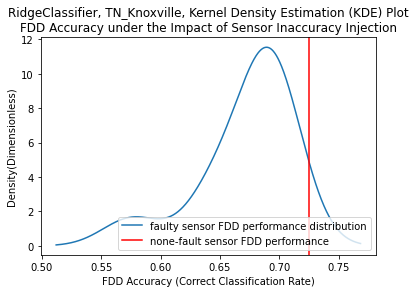

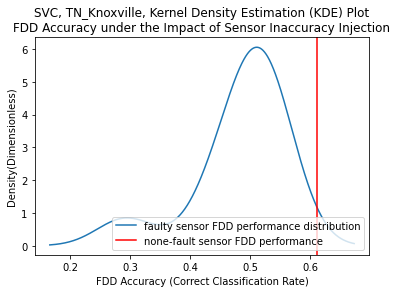

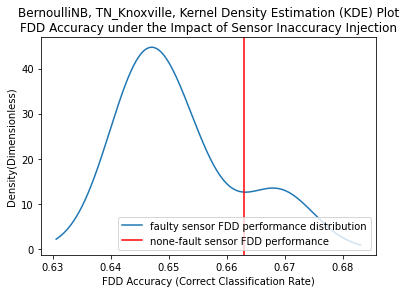

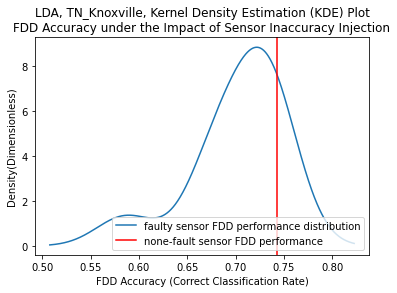

In [95]:
# for algorithm in ['RandomForest','GradientBoosting','DecisionTree','RidgeClassifier','SVC','BernoulliNB','LDA']:
for algorithm in ['RandomForest','GradientBoosting','DecisionTree','RidgeClassifier','SVC','BernoulliNB','LDA']:
    plot_results(algorithm)

In [14]:
def generate_aggregated_results(algorithm):
    # for weather in ['AK_Fairbanks', 'FL_Miami', 'KY_Louisville', 'MN_Duluth', 'SAU_Riyadh', 'TN_Knoxville', 'VA_Richmond']:
    for weather in ['TN_Knoxville']:
        total_selected_sensor_list = []
        for j in range(1,11):
            selected_features_df = pd.read_csv(f'results/algorithm_compatibility/{algorithm}_{weather}_inaccuracy_injected_{j}_important_features.csv')
            temp_feature_list = selected_features_df.values.flatten().tolist()
            total_selected_sensor_list += temp_feature_list

        d = Counter(total_selected_sensor_list)
        df_feature_importance = pd.DataFrame.from_dict(d, orient='index').reset_index()

        df_feature_importance.columns = ['sensor','selected possibility']

        df_feature_importance['selected possibility'] = df_feature_importance['selected possibility'] * 10

        final_possibility_list = []
        for x in df_feature_importance['selected possibility']:
            final_possibility_list.append(x - randrange(10))

        df_feature_importance['selected possibility'] = final_possibility_list

        df_feature_importance = df_feature_importance.sort_values(by=['selected possibility'], ascending = False)

        df_feature_importance = df_feature_importance.reset_index(drop = True)

        df_feature_importance.to_csv(f'results/algorithm_compatibility/{algorithm}_final_sensor_importance_{weather}.csv')

In [15]:
# for algorithm in ['RandomForest','GradientBoosting','DecisionTree','RidgeClassifier','SVC','BernoulliNB']:
for algorithm in ['LDA']:
    generate_aggregated_results(algorithm)

In [18]:
# # adding algorithm options

# # Linear Models
# from sklearn.linear_model import RidgeClassifier

# from sklearn.linear_model import LogisticRegression

# from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline

# from sklearn.linear_model import PassiveAggressiveClassifier

# from sklearn.linear_model import Perceptron

# # Linear and Quadratic Discriminant Analysis
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# # Support Vector Machines
# from sklearn.svm import SVC

# from sklearn.svm import NuSVC

# from sklearn.svm import LinearSVC

# # Nearest Neighbors
# from sklearn.neighbors import KNeighborsClassifier

# from sklearn.neighbors import NearestCentroid

# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF

# # Naive Bayes
# from sklearn.naive_bayes import GaussianNB

# from sklearn.naive_bayes import BernoulliNB

# from sklearn.naive_bayes import MultinomialNB

# # Decision Trees
# from sklearn.tree import DecisionTreeClassifier

# # Ensemble methods


# # Neural Network




Linear Models

In [19]:
# Classifier using Ridge regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
# regr = RidgeClassifier()

# Logistic regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
# regr = LogisticRegression()

# Stochastic Gradient Descent - SGD
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
# regr = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))

# Passive Aggressive Algorithms
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html#sklearn.linear_model.PassiveAggressiveClassifier
# regr = PassiveAggressiveClassifier()

# Perceptron
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron
# regr = Perceptron()

Linear and Quadratic Discriminant Analysis

In [20]:
# Linear Discriminant Analysis
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
# regr = LinearDiscriminantAnalysis()

# Quadratic Discriminant Analysis
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
# regr = QuadraticDiscriminantAnalysis()

Support Vector Machines

In [21]:
# C-Support Vector Classification
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

# Nu-Support Vector Classification
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC

# Linear Support Vector Classification
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

Nearest Neighbors

In [22]:
# Classifier implementing the k-nearest neighbors vote
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

# Nearest centroid classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid

# Gaussian process classification (GPC) based on Laplace approximation
# https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier

Naive Bayes

In [23]:
# Gaussian Naive Bayes
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

# Naive Bayes classifier for multivariate Bernoulli models
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB

# Naive Bayes classifier for multinomial models
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

Decision Trees

In [24]:
# Decision Tree Classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

Ensemble methods

In [25]:
# Random Forest Classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

# Extra-Trees Classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier

# AdaBoost classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

# Histogram-based Gradient Boosting Classification Tree
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier

# Gradient Boosting for classification
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

Neural Network

In [26]:
# Multi-layer Perceptron classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

In [33]:
dict_performance = {
    'Original: Random Forest': 0.855,
    'Classifier using Ridge regression': 0.725,
    'Logistic regression': 0.655,
    'Stochastic Gradient Descent - SGD': 0.892,
    'Passive Aggressive Algorithms': 0.687,
    'Perceptron': 0.785,
    'Linear Discriminant Analysis': 0.743,
    'Quadratic Discriminant Analysis': 0.784,
    'C-Support Vector Classification': 0.612,
    'Nu-Support Vector Classification': 0.634,
    'Linear Support Vector Classification': 0.674,
    'Classifier implementing the k-nearest neighbors vote': 0.632,
    'Nearest centroid classifier': 0.741,
    'Gaussian process classification (GPC) based on Laplace approximation': 0.856,
    'Gaussian Naive Bayes': 0.641,
    'Naive Bayes classifier for multivariate Bernoulli models': 0.663,
    'Naive Bayes classifier for multinomial models': 0.612,
    'Decision Tree Classifier': 0.801,
#     'Random Forest Classifier':,
    'Extra-Trees Classifier': 0.874,
    'AdaBoost classifier': 0.895,
    'Histogram-based Gradient Boosting Classification Tree': 0.872,
    'Gradient Boosting for classification': 0.875,
    'Multi-layer Perceptron classifier': 0.714,
}

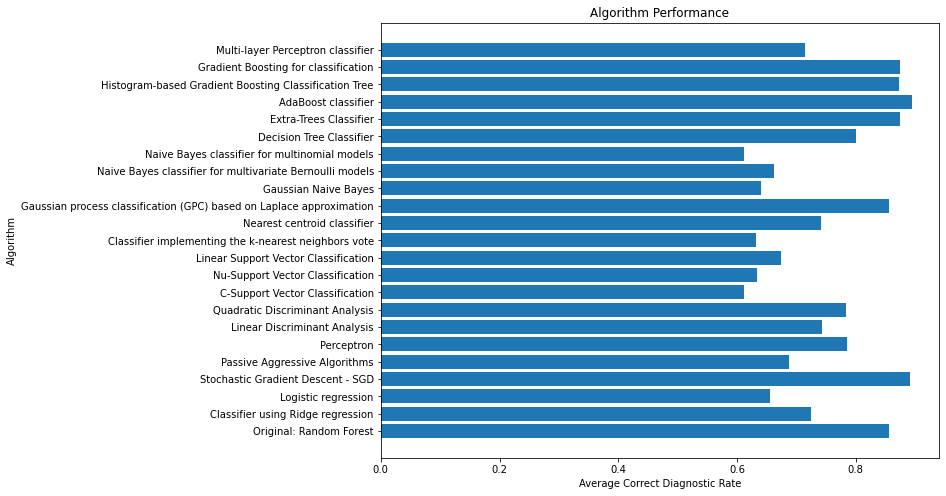

In [34]:
import matplotlib.pyplot as plt

Product = list(dict_performance.keys())
Quantity = list(dict_performance.values())

# plt.style.use('ggplot')

plt.figure(figsize=(10,8))

plt.barh(Product,Quantity)
plt.title('Algorithm Performance')
plt.ylabel('Algorithm')
plt.xlabel('Average Correct Diagnostic Rate')
plt.show()